<a href="https://colab.research.google.com/github/Aleena24/srgan_cloud/blob/main/srgan_cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aleenavarghese24","key":"6bee7aaf222e0a190e8e67f9f700b75c"}'}

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install kaggle

In [4]:
!kaggle datasets download -d apollo2506/eurosat-dataset

Dataset URL: https://www.kaggle.com/datasets/apollo2506/eurosat-dataset
License(s): CC0-1.0
100% 2.04G/2.04G [00:29<00:00, 107MB/s] 
100% 2.04G/2.04G [00:29<00:00, 73.7MB/s]


In [5]:
!unzip eurosat-dataset.zip -d ./EuroSat

Streaming output truncated to the last 5000 lines.
  inflating: ./EuroSat/EuroSATallBands/River/River_1990.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1991.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1992.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1993.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1994.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1995.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1996.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1997.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1998.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_1999.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_2.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_20.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_200.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_2000.tif  
  inflating: ./EuroSat/EuroSATallBands/River/River_2001.tif  
  inflating: ./EuroSat/Eu

In [6]:
!pip install highlight_text

In [11]:
import numpy as np
import pandas as pd
import random

import os
from os import listdir, mkdir, rename
from os.path import join, exists
import shutil
import datetime

import matplotlib.pyplot as plt
from highlight_text import ax_text, fig_text
from PIL import Image

import warnings

warnings.filterwarnings('ignore')

In [8]:
classes = listdir('./EuroSat')
path_target = './EuroSat/all_targets'
path_input = './EuroSat/all_inputs'

In [12]:
# Process the dataset
classes = [d for d in os.listdir(path_input) if isdir(join(path_input, d))]
k = 1
for kind in classes:
    path = join(path_input, str(kind))
    for i, f in enumerate(os.listdir(path)):
        source_path = join(path, f)
        if isfile(source_path):
            target_path = join(path_target, f'{k}.jpg')
            shutil.copyfile(source_path, target_path)
            k += 1

print("Dataset processing complete.")

Dataset processing complete.


In [13]:
def generate_perlin_noise(width, height, scale, octaves, persistence, lacunarity):
    noise = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            noise[i][j] = pnoise2(i / scale,
                                  j / scale,
                                  octaves=octaves,
                                  persistence=persistence,
                                  lacunarity=lacunarity,
                                  repeatx=width,
                                  repeaty=height,
                                  base=0)
    return noise

def normalize_noise(noise):
    min_val = noise.min()
    max_val = noise.max()
    return (noise - min_val) / (max_val - min_val)

def generate_clouds(width, height, base_scale, octaves, persistence, lacunarity):
    clouds = np.zeros((height, width))
    for octave in range(1, octaves + 1):
        scale = base_scale / octave
        layer = generate_perlin_noise(width, height, scale, 1, persistence, lacunarity)
        clouds += layer * (persistence ** octave)

    clouds = normalize_noise(clouds)
    return clouds

def overlay_clouds(image, clouds, alpha=0.5):

    clouds_rgb = np.stack([clouds] * 3, axis=-1)

    image = image.astype(float) / 255.0
    clouds_rgb = clouds_rgb.astype(float)

    blended = image * (1 - alpha) + clouds_rgb * alpha

    blended = (blended * 255).astype(np.uint8)
    return blended

In [14]:
width, height = 64, 64
octaves = 12 #number of noise layers combined
persistence = 0.5 #lower persistence reduces the amplitude of higher-frequency octaves
lacunarity = 2 #higher lacunarity increases the frequency of higher-frequency octaves
for i in range(len(listdir(path_target))):
  base_scale = random.uniform(5,120) #noise frequency
  alpha = random.uniform(0,1) #transparency

  clouds = generate_clouds(width, height, base_scale, octaves, persistence, lacunarity)

  img = np.asarray(Image.open(join(path_target, f'{i+1}.jpg')))
  image = Image.fromarray(overlay_clouds(img,clouds, alpha))
  image.save(join(path_input,f'{i+1}.jpg'))
  print(f'Processed {i+1}/{len(listdir(path_target))}')

FileNotFoundError: [Errno 2] No such file or directory: './EuroSat/all_targets/9949.jpg'

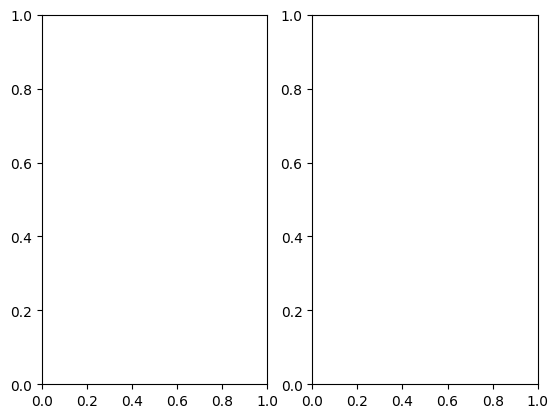

In [15]:
idx = np.random.randint(27000)
fig,ax = plt.subplots(1,2)
ax[0].imshow(np.asarray(Image.open(join(path_target, f'{idx}.jpg'))))
ax[1].imshow(np.asarray(Image.open(join(path_input, f'{idx}.jpg'))))
ax[0].set_title("Target")
ax[0].axis('off')
ax[1].set_title("Input")
ax[1].axis('off')
plt.show()